<a href="https://colab.research.google.com/github/min-program/deep_learning_class/blob/main/%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1%EB%AA%A8%EB%8D%B8_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torchvision import utils
import matplotlib.pyplot as plt
import glob
%matplotlib inline

import numpy as np
import glob 
from torchvision import transforms 
from PIL import Image 
from torch.utils.data import Dataset, DataLoader 
import pandas as pd
import os

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/btc_label.csv')
df

,Date,Price,Open,High,Low,Change,cal,Label
0,2017.9.26,4320000,4319000,4420000,4306000,0.000,1,2
1,2017.9.27,4654000,4320000,4680000,4313000,0.077,2,0
2,2017.9.28,4592000,4654000,4791000,4518000,-0.013,0,2
3,2017.9.29,4658000,4592000,4710000,4478000,0.014,2,2
4,2017.9.30,4891000,4658000,4898000,4654000,0.050,2,2
...,...,...,...,...,...,...,...,...
1672,2022.4.25,50633000,49617000,50897000,48560000,0.020,2,0
1673,2022.4.26,48710000,50623000,51147000,48202000,-0.038,0,2
1674,2022.4.27,49918000,48720000,50067000,48570000,0.025,2,2
1675,2022.4.28,50549000,49915000,51169000,49667000,0.013,2,0


In [ ]:
class Dataset(Dataset): 
    def __init__(self, path, train=True, transform=None): 
        df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/btc_label.csv')
        self.path = path 
        
        self.train_path = path + '/train'  
        self.test_path = path + '/test'
            
        self.train_list = glob.glob(self.train_path + '/*.jpg') 
        self.test_list = glob.glob(self.test_path + '/*.jpg') 
        
        self.transform = transform 
        
        self.img_list = self.train_list + self.test_list 
        
        self.Image_list = []  
        for img_path in self.img_list: 
            self.Image_list.append(Image.open(img_path))
        
        self.class_list = df['Label']
        
    def __len__(self): 
        return len(self.img_list)
    
    def __getitem__(self, idx): 
        img = self.Image_list[idx] 
        label = self.class_list[idx]
        
        if self.transform is not None: 
            img = self.transform(img) 
            
        
        return img, label 

if __name__ == "__main__": 
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]) 
    
    train_ds = Dataset(path='/content/drive/MyDrive/Colab Notebooks', train=True, transform=transform)
    trainloader = DataLoader(dataset=train_ds, batch_size=1, shuffle=True, drop_last=False)
    
    test_ds = Dataset(path='/content/drive/MyDrive/Colab Notebooks', train=False, transform=transform)
    testloader = DataLoader(dataset=test_ds, batch_size=1, shuffle=True, drop_last=False)
     
    
    for epoch in range(1): 
        #print(f"epoch : {epoch} ") 
        for batch in trainloader: 
            img, label = batch 
            #print(img.size(), label)


tensor(2)


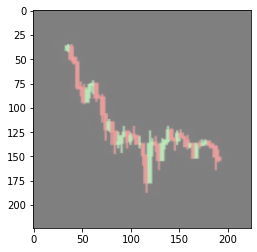

In [ ]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(torchvision.utils.make_grid(labels))

In [ ]:
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [ ]:
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [ ]:
class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_3_block(2*base_dim,4*base_dim), #256
            conv_3_block(4*base_dim,8*base_dim), #512
            conv_3_block(8*base_dim,8*base_dim), #512        
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로 
            #nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [ ]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 8

In [ ]:
# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# VGG 클래스를 인스턴스화
model = VGG(base_dim=64).to(device)

# 손실함수 및 최적화함수 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            #3 224 128
            nn.Conv2d(3, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #64 112 64
            nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #128 56 32
            nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #256 28 16
            nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #512 14 8
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
        #512 7 4

        self.avg_pool = nn.AvgPool2d(7)
        #512 1 1
        self.classifier = nn.Linear(512, 10)
        """
        self.fc1 = nn.Linear(512*2*2,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,10)
        """

    def forward(self, x):

        #print(x.size())
        features = self.conv(x)
        #print(features.size())
        x = self.avg_pool(features)
        #print(avg_pool.size())
        x = x.view(features.size(0), -1)
        #print(flatten.size())
        x = self.classifier(x)
        #x = self.softmax(x)
        return x, features

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net()
net = net.to(device)
param = list(net.parameters())
print(len(param))
for i in param:
    print(i.shape)
#print(param[0].shape)

28
torch.Size([128, 3, 3, 3])
torch.Size([128])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [ ]:
model.train()
loss_arr = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(trainloader):
        x=image.to(device)
        y_=label.to(device)

        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()

        if j%1000==0:
            print(j, loss)
            loss_arr.append(loss.cpu().detach().numpy())

0 tensor(0.9864, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(0.9295, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.3383, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.1458, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.1340, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.4308, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.0254, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.1452, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.9784, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.1578, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.1635, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(0.8661, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.2716, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.0812, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.0025, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(0.9360, device='cuda:0', grad_fn=<Nll

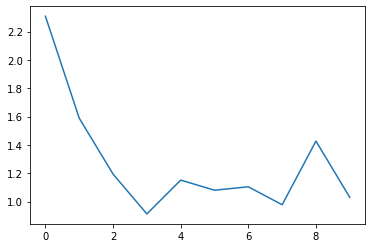

In [ ]:
plt.plot(loss_arr)
plt.show()

In [ ]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

model.eval()

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in testloader:
        
        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        _,output_index = torch.max(output,1)

        
        # 전체 개수 += 라벨의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()
    
    # 정확도 도출
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 36.73225784301758%
